# FLAN-T5

## What is [FLAN-T5](https://arxiv.org/pdf/2210.11416.pdf)?

* FLAN-T5 is an open-source, sequence-to-sequence language model developed by Google researchers in late 2022. It is capable of performing various natural language processing tasks and can be used both in research and commercial applications. The model is based on the Transformer architecture and trained on a large corpus of text known as the Colossal Clean Crawled Corpus (C4).

* Fine-tuning FLAN-T5 is essential to adapt it to specific tasks and improve its performance. This process allows customization of the model according to the user's needs and data, making it accessible to a wider range of users, including smaller organizations and individual researchers without GPU resources.

* Instruction fine-tuning is a technique used to customize pre-trained large language models (LLMs) to perform specific tasks based on explicit instructions or demonstrations. Unlike traditional fine-tuning, which involves training a model on task-specific data, instruction fine-tuning provides higher-level guidance to the model to shape its behavior according to predefined instructions.

  * Instruction: Analyze the sentiment of the text and determine whether it's positive or negative.

  * Input_text: "I thoroughly enjoyed the movie; it was fantastic."

  * Output_text: Positive, Negative

## Potential Applications
Potential applications of fine-tuned FLAN-T5 include:
- **Text summarization:** Condensing large amounts of text into concise summaries..
- **Text Classification:** Categorizing text data into predefined classes (e.g., spam or non-spam, positive or negative sentiment)..
- **Domain-Specific Question Answering:** Whether it's medical, legal, or technical domains, fine-tuned FLAN-T5 models can be tailored to answer questions specific to different industries or subjects with high accuracy.

Fine-tuning FLAN-T5 opens up possibilities for optimizing its performance in various real-world scenarios.


### Library

In [10]:
!pip install nltk
!pip install datasets
!pip install transformers[torch]
!pip install tokenizers
!pip install evaluate
!pip install rouge_score
!pip install sentencepiece
!pip install huggingface_hub
!pip install tabulate

### Imports

In [11]:
import nltk
import evaluate
import pandas as pd
import numpy as np
from tabulate import tabulate
from datasets import load_dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [3]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=FVns3qUl8RVh0PHW6B5ol63ErCbgY%2FK-KHxUoMRmOSg'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/usr/bin/open: 882: www-browser: not found
/usr/bin/open: 882: links2: not found
/usr/bin/open: 882: elinks: not found
/usr/bin/open: 882: links: not found
/usr/bin/open: 882: lynx: not found
/usr/bin/open: 882: w3m: not found
xdg-open: no method available for opening

### Dataset preparation

In [12]:
import pandas as pd

# Given dataset
data=pd.read_csv('/content/gdrive/My Drive/research/finalfeatures.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Function to generate input and output
def generate_input_output(row):
    # Formulate the question
    input_text = f"For store number {row['store_nbr']} in the city of {row['city']}, with products from various categories such as {row['family']}, during a {row['type_of_holiday'].lower()} on {row['year']}-{row['month']}-{row['day']}, with {'no' if row['onpromotion'] == 0 else 'promotions'}, cluster {row['cluster']}, and WTI crude oil price at ${row['dcoilwtico']}, what were the total sales on that day?"

    # Provide the answer
    output_text = row['sales']

    return input_text, output_text

# Generate input_output pairs using list comprehension
input_output_pairs = [generate_input_output(row) for _, row in df.iterrows()]

# Extract input and output into separate lists
input_text, output_text = zip(*input_output_pairs)

# Create a DataFrame from the lists
question_answer_df = pd.DataFrame({'input_text': input_text, 'output_text': output_text})

# Save the dataframe to a file
question_answer_df.to_csv('/content/gdrive/My Drive/research/datasetqa.csv', index=False)


In [14]:
def print_df(df):
    print(tabulate(df.head(5), headers=df.columns, tablefmt='psql'))

print_df(question_answer_df)


+----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|    | input_text                                                                                                                                                                                                                               |   output_text |
|----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------|
|  0 | For store number 1.0 in the city of Quito, with products from various categories such as AUTOMOTIVE, during a holiday on 2013-2-11, with no, cluster 13, and WTI crude oil price at $97.01, what were the total sales on th

In [5]:
import pandas as pd
import json

def format_and_save_to_json(input_csv_path, output_json_path):
    # Read data from CSV
    data = pd.read_csv(input_csv_path)

    # Convert DataFrame to list of dictionaries in desired format
    formatted_data = []
    for idx, row in data.iterrows():
        formatted_data.append({
            "input_text": row['input_text'],
            "output_text": row['output_text'],
            "id": str(idx)  # Adding an ID based on index
        })

    # Save data as JSON
    with open(output_json_path, "w") as json_file:
        json.dump(formatted_data, json_file, indent=4)

# Example usage
input_csv_path = "/content/gdrive/My Drive/research/datasetqa.csv"
output_json_path = "/content/gdrive/My Drive/research/formatted_data.json"

format_and_save_to_json(input_csv_path, output_json_path)


In [17]:
import json

def print_json_rows(json_file_path, num_rows):
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    # Print specified number of rows
    for i in range(num_rows):
        print(json.dumps(data[i], indent=4))

# Specify the number of rows you want to print
num_rows_to_print = 5

# Call the function to print rows from the JSON file
print_json_rows(output_json_path, num_rows_to_print)


{
    "input_text": "For store number 1.0 in the city of Quito, with products from various categories such as AUTOMOTIVE, during a holiday on 2013-2-11, with no, cluster 13, and WTI crude oil price at $97.01, what were the total sales on that day?",
    "output_text": 0.0,
    "id": "0"
}
{
    "input_text": "For store number 1.0 in the city of Quito, with products from various categories such as MAGAZINES, during a holiday on 2013-2-11, with no, cluster 13, and WTI crude oil price at $97.01, what were the total sales on that day?",
    "output_text": 0.0,
    "id": "1"
}
{
    "input_text": "For store number 1.0 in the city of Quito, with products from various categories such as LIQUOR,WINE,BEER, during a holiday on 2013-2-11, with no, cluster 13, and WTI crude oil price at $97.01, what were the total sales on that day?",
    "output_text": 21.0,
    "id": "2"
}
{
    "input_text": "For store number 1.0 in the city of Quito, with products from various categories such as LINGERIE, duri

#Loading the model

## Google's FLAN-T5 Models on Hugging Face

Here are five publicly available versions of Google's FLAN-T5 models hosted on Hugging Face:

## [flan-t5-small](https://huggingface.co/google/flan-t5-small):

- **Parameters:** 80 Million
- **Download size:** 300 MB
- **Best suited for:** Tasks requiring minimal computational resources, like simple text summarization or question answering.

## [flan-t5-base](https://huggingface.co/google/flan-t5-base):

- **Parameters:** 250 Million
- **Download size:** 1 GB
- **Best suited for:** Balancing performance and resource requirements for various tasks, including text classification, summarization, and code generation.

## [flan-t5-large](https://huggingface.co/google/flan-t5-large):

- **Parameters:** 780 Million
- **Download size:** 4 GB
- **Best suited for:** Complex tasks requiring higher accuracy and performance, such as translation, dialogue generation, and creative writing.

## [flan-t5-xl](https://huggingface.co/google/flan-t5-xl):

- **Parameters:** 3 Billion
- **Download size:** 12 GB
- **Best suited for:** Research purposes and demanding tasks requiring the highest performance, like large-scale summarization or complex code generation.

## [flan-t5-xxl](https://huggingface.co/google/flan-t5-xxl):

- **Parameters:** 11 Billion
- **Download size:** 44 GB
- **Best suited for:** Advanced research and pushing the boundaries of NLP capabilities, but requires significant computational resources.


In [18]:
# Load the tokenizer, model, and data collator

MODEL_NAME = "google/flan-t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### HuggingFace Datasets

HuggingFace Datasets is a lightweight library designed for sharing and accessing datasets and evaluation metrics for Natural Language Processing (NLP). It offers compatibility with NumPy, Pandas, PyTorch, and TensorFlow, and features a user-friendly interface. With built-in interoperability and efficient memory usage, it provides access to a rich collection of NLP datasets and evaluation metrics, making it easy for the community to add and share new datasets. Originating from TensorFlow Datasets, it offers smart caching mechanisms and is optimized for handling large datasets effectively.

In [19]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
question_answer_da = load_dataset('/content/gdrive/My Drive/research/dataset.py')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:926: FutureWarning: The repository for dataset contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/gdrive/My Drive/research/dataset.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
question_answer_da = question_answer_da["train"].train_test_split(test_size=0.2)
# Check the length of the data and its structure
question_answer_da

DatasetDict({
    train: Dataset({
        features: ['id', 'input_text', 'output_text'],
        num_rows: 257637
    })
    test: Dataset({
        features: ['id', 'input_text', 'output_text'],
        num_rows: 64410
    })
})

In [21]:
# instruction of our tasks with "output_text the input_text"
instruction = "Please answer this question: This is a store sales time series forecasting . Where you need to predict store sales using data from Corporacion Favorita, a prominent grocery retailer based in Ecuador. Your task is to predict the accurately forecast the unit of sales based on the input  "

# Define the preprocessing function

def preprocess_function(examples):
   """Add instruction to the sentences, tokenize the text, and set the labels"""
   # The "inputs" are the tokenized answer:
   inputs = [instruction + doc for doc in examples["input_text"]]
   model_inputs = tokenizer(inputs, max_length=128, truncation=True)

   # The "labels" are the tokenized outputs:
   labels = tokenizer(text_target=examples["output_text"],
                      max_length=512,
                      truncation=True)

   model_inputs["labels"] = labels["input_ids"]
   return model_inputs

# Map the preprocessing function across our dataset
tokenized_dataset = question_answer_da.map(preprocess_function, batched=True)

Two commonly used metrics in the field of NLP evaluation are BLEU and ROUGE scores.

#### BLEU Score:

- BLEU is primarily used in machine translation tasks, where the goal is to assess the quality of machine-generated translations compared to human-generated reference translations.
- It measures the precision of n-grams (contiguous sequences of n words) in the machine-generated translation by comparing them to the reference translations.
- BLEU accounts for brevity by applying a brevity penalty to shorter translations.
BLEU = BP * exp(∑ pn)

  *   BP (Brevity Penalty) adjusts the score for shorter.translations compared to reference translations. It's calculated as min(1, (reference_length / translated_length)).
  *   pn represents the precision of n-grams, calculated as the number of overlapping n-grams divided by the total number of n-grams in the translation.


- The score ranges from 0 to 1, with higher values indicating better translation quality.

#### ROUGE Score:

- ROUGE is commonly employed in text summarization tasks to evaluate the quality of machine-generated summaries against human-generated reference summaries.
- It measures the recall of n-grams in the machine-generated summary by comparing them to the reference summaries.
- ROUGE offers various variants such as ROUGE-N, ROUGE-L, and ROUGE-S, each focusing on different aspects of summarization quality.

  The formula for ROUGE score is as follows:
ROUGE = ∑ (Recall of n-grams)

  Where:

  *  Recall of n-grams is the number of n-grams that appear in both the machine-generated summary and the reference summaries divided by the total number of n-grams in the reference summaries.

- Like BLEU, the score ranges from 0 to 1, with higher values indicating better summary quality.


In [22]:
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
   preds, labels = eval_preds

   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

   result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

   return result

Map:   0%|          | 0/257637 [00:00<?, ? examples/s]

Map:   0%|          | 0/64410 [00:00<?, ? examples/s]

In [23]:
# Global Parameters
L_RATE = 3e-4
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 4
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 3

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="/content/gdrive/My Drive/research/Model/llm1.0",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

In [ ]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss


Results [Here](https://huggingface.co/Jyotiyadav/model2.0)

Demo - [Forecasting_model](https://huggingface.co/spaces/Jyotiyadav/Forecasting_model)



* **Rouge1**: Measures the overlap of unigrams (single words) between the generated and reference text.

* **Rouge2**: Measures the overlap of bigrams (sequences of two words) between the generated and reference text.

* **RougeL**: Measures the longest common subsequence between the generated and reference text.

* **RougeLsum**: Measures the sum of the RougeL scores over the entire text.

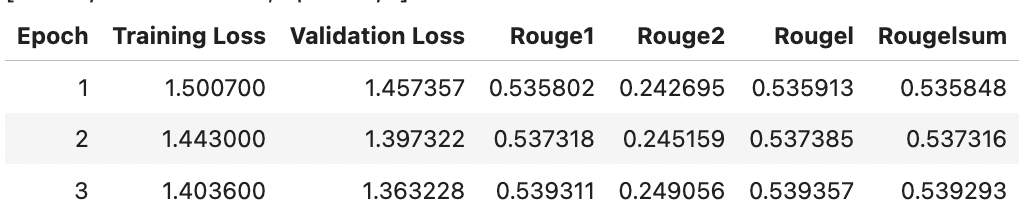

#Inference

## Online prediction

In [ ]:
last_checkpoint = "Jyotiyadav/model2.0"

finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

In [ ]:
import pandas as pd

# Given dataset
data = pd.read_csv('/content/gdrive/My Drive/research/submission_encoded_dataset.csv')

# Fill missing values with 0
data['transactions'] = data['transactions'].fillna(0)
data['type_of_holiday'] = data['type_of_holiday'].fillna(0)

# Create DataFrame
df = pd.DataFrame(data)

# Function to generate question
def generate_question(row):
    # Formulate the question
    question = f"For store number {row['store_nbr']} in the city of {row['city']}, with products from various categories such as {row['family']}, during a {str(row['type_of_holiday']).lower()} on {row['year']}-{row['month']}-{row['day']}, with {'no' if row['onpromotion'] == 0 else 'promotions'}, cluster {row['cluster']}, and WTI crude oil price at ${row['dcoilwtico']}, what were the total sales on that day?"

    return question

# Generate questions using list comprehension
questions = [generate_question(row) for _, row in df.iterrows()]

# Create a DataFrame for questions
questions_df = pd.DataFrame({'question': questions})

# Save the dataframe to a file
questions_df.to_csv('datasetqatest.csv', index=False)

questions_df.head(5)


,question
0,"For store number 1 in the city of Quito, with ..."
1,"For store number 1 in the city of Quito, with ..."
2,"For store number 1 in the city of Quito, with ..."
3,"For store number 1 in the city of Quito, with ..."
4,"For store number 1 in the city of Quito, with ..."


In [ ]:
my_question = "For store number 1 in the city of Quito, with products from various categories such as AUTOMOTIVE, during a 0 on 2017-8-16, with no, cluster 13, and WTI crude oil price at $46.8, what were the total sales on that day?"
inputs = ["Please answer this question: " + my_question]

In [ ]:
inputs = tokenizer(inputs, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
answer = tokenizer.decode(outputs[0])
#print(answer)
from textwrap import fill

print(fill(answer, width=80))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<pad> 5.0</s>


### Batch Inference

In [ ]:
import pandas as pd

# Assuming you have already imported the necessary libraries and defined the functions and model

# Load the DataFrame from the CSV file
df = pd.read_csv("/content/gdrive/datasetqatest.csv")

# Function to generate answer for a given question
def generate_answer_batch(questions):
    inputs = tokenizer(["Please answer this question: " + question for question in questions], return_tensors="pt", padding=True, truncation=True)
    outputs = finetuned_model.generate(**inputs)
    answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return answers

# Generate predictions for all questions in the DataFrame
batch_size = 100  # Adjust as needed
predicted_answers = []
for i in range(0, len(df), batch_size):
    questions_batch = df['question'][i:i+batch_size].tolist()
    answers_batch = generate_answer_batch(questions_batch)
    predicted_answers.extend(answers_batch)

# Add the predicted answers to the DataFrame
df['predicted_answer'] = predicted_answers

# Save the DataFrame to a CSV file
df.to_csv('/content/gdrive/My Drive/research/predicted_answer.csv', index=False)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
df1=pd.read_csv('/content/test.csv')
# Select only the 'id' column from dataframe1
id_column = df1['id']
predictions = df['predicted_answer']
# Combine id_column and predicted_answers into a new DataFrame
dataframe2 = pd.DataFrame({'id': id_column, 'predictions': predicted_answers})

# Save the dataframe2 to a CSV file
dataframe2.to_csv('/content/gdrive/My Drive/research/submission.csv', index=False)

In [ ]:
dataframe2

,id,predictions
0,3000888,5.0
1,3000889,0.0
2,3000890,1.0
3,3000891,1412.0
4,3000892,0.0
...,...,...
28507,3029395,319.299
28508,3029396,88.7
28509,3029397,2193.923
28510,3029398,6.0


In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the data
dataframe2.rename(columns={"predictions": "sales"}, inplace=True)


In [ ]:
# Save the dataframe2 to a CSV file
dataframe2.to_csv('/content/gdrive/My Drive/research/submission.csv', index=False)

### Submission Public Score

[Kaggle Leaderboard](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/leaderboard#)